In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Standard Libraries
import os
from os import listdir
import pickle
#import optuna
import librosa
import numpy as np
import pandas as pd
from datetime import datetime

#Plots and Visuals
import re
import black
import jupyter_black
#jupyter_black.load(lab=False, line_length=120)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 6)
plt.style.use('ggplot')
sns.set_style("darkgrid")
from scipy import stats

#Sci-kit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.metrics import RSquare

#Keras - Tensorflow
import keras
from keras import layers
#import keras_tuner as kt
import tensorflow as tf

devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], True)
from keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import (
    Input, Flatten, Normalization, Embedding, Dense, Dropout, SpatialDropout2D, Activation,
    Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, GlobalAvgPool1D, GlobalAveragePooling2D, LeakyReLU,
    Concatenate, Reshape, Bidirectional, GRU, LSTM, TimeDistributed, GlobalMaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

2022-11-15 20:04:21.726687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 20:04:21.785161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 20:04:21.785356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def plot_learning_curves(model_history):
    # Plotting the MSE and the loss learning curves side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    MSE = model_history["mse"]
    val_MSE = model_history["val_mse"]
    epochs = range(1, len(MSE) + 1)
    ax1.plot(epochs, MSE, "g--", label="Training MSE")
    ax1.plot(epochs, val_MSE, "g", label="Validation MSE")
    ax1.set_title("Training and validation MSE", fontsize=15)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("MSE")
    ax1.legend()
    loss = model_history["loss"]
    val_loss = model_history["val_loss"]
    ax2.plot(epochs, loss, "r--", label="Training loss")
    ax2.plot(epochs, val_loss, "r", label="Validation loss")
    ax2.set_title("Training and validation loss", fontsize=15)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    return plt.show()

In [3]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [4]:
def report(model, X_test):
    predictions = model.predict(X_test).flatten().round(0).astype(int)

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    temp = pd.DataFrame(model.predict(X_test).flatten().round(0).astype(int), index=X_audio_test.index)
    true_ranks = y_test.argsort().argsort()
    predicted_ranks = temp.iloc[:,0].argsort().argsort()

    metric = RSquare()
    metric.update_state(y_test, predictions)
    result = metric.result()
    R2 = result.numpy()

    sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
    print(f"MAE: {mae}\nMSE: {mse}\nSpearman's Correlation: {sp[0]}\nR Squared: {R2}")

    results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)

    ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
    ax.set(xlabel='Golden Truth', ylabel='Predictions');
    plt.ylim(reversed(plt.ylim()));
    plt.yticks(rotation=90);
    
    return mae, mse, sp, R2

In [5]:
#Spotify Features    
with open("spotify_features.pkl", "rb") as z:
    (X_audio_train, X_audio_val, X_audio_test) = pickle.load(z)
    
#Genres
with open("genres.pkl", "rb") as z:
    (X_genres_train, X_genres_val, X_genres_test) = pickle.load(z)

#Mel Spectrograms
with open("mel_spectrograms.pkl", "rb") as z:
    (X_mel_train, X_mel_val, X_mel_test) = pickle.load(z)
    
#Youtube Views
#Mel Spectrograms
with open("youtube_views.pkl", "rb") as z:
    (X_views_train, X_views_val, X_views_test) = pickle.load(z)
    
#Target
with open("target.pkl", "rb") as z:
    (y_train, y_val, y_test) = pickle.load(z)
    
print(list(X_audio_train.columns))

['explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year', 'month', 'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0']


In [6]:
base_w = 1 / pd.Series(y_train).value_counts() / y_train.shape[0] * 10000
base_w = base_w.to_dict()
sample_weight = np.array([np.round(base_w[x], 2) for x in y_train]) + 10

In [7]:
#(timesteps, features)
X_mel_train = np.array([scale_minmax(x, -1, 1) for x in X_mel_train.mel_spectrogram])
X_mel_val = np.array([scale_minmax(x, -1, 1) for x in X_mel_val.mel_spectrogram])
X_mel_test = np.array([scale_minmax(x, -1, 1) for x in X_mel_test.mel_spectrogram])
    
#X_mel_train = np.array([x for x in X_mel_train.values])
X_mel_train = X_mel_train.transpose((0,2,1)).reshape(X_mel_train.shape[0], 1292, 128)

#X_mel_val = np.array([x for x in X_mel_val.values])
X_mel_val = X_mel_val.transpose((0,2,1)).reshape(X_mel_val.shape[0], 1292, 128)

#X_mel_test = np.array([x for x in X_mel_test.values])
X_mel_test = X_mel_test.transpose((0,2,1)).reshape(X_mel_test.shape[0], 1292, 128)

X_mel_train.shape

(8601, 1292, 128)

# Before Song Release

In [8]:
def embedding_model(n_layers=6):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    audio_input = Input(shape= (X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")
    
    #Spectrograms
    x = Conv1D(filters= 128, kernel_size= 11, padding='same', activation='relu')(mel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(n_layers - 1):
        x = Conv1D(32 * (2**i), kernel_size=11, strides=3 , padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=4, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

    x = GlobalAvgPool1D()(x)
    #x = Flatten()(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    mel_out = Dropout(0.3)(x)
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    y = Dropout(0.4)(hidden_layer)
    
    hidden_layer = Dense(32, activation = 'swish')(genres_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(96, activation = 'selu')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(256, activation = 'relu')(dropout)
    e = Dropout(0.6)(hidden_layer)
    
    audio_genres_out = Concatenate(axis=1, name="AUDIO_GENRE_OUTPUT")([y, e])
    
    #Combined inputs are passed through a final MLP network
    embeddings = Concatenate(axis=1, name='embeddings')([mel_out, audio_genres_out]) #64+64 = 128-D embedding representation for every song
    print(embeddings.shape)
    
    out = Dense(1)(embeddings)

    model = Model(inputs=[mel_input, audio_input, genres_input], outputs=out)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

Change concat sizes according to ones that contribute the most

In [9]:
keras.backend.clear_session()
model = embedding_model()

(None, 352)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1292, 128)    180352      ['MEL_INPUT[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 646, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 646, 128)    512         ['max_pooling1d[0][0]']          
 alization)                                                                       

2022-11-15 18:10:00.158668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 18:10:00.165186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:10:00.166345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:10:00.166491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

 max_pooling1d_5 (MaxPooling1D)  (None, 1, 512)      0           ['conv1d_5[0][0]']               
                                                                                                  
 dense_2 (Dense)                (None, 256)          7424        ['AUDIO_INPUT[0][0]']            
                                                                                                  
 dropout_10 (Dropout)           (None, 176)          0           ['dense_7[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 1, 512)      2048        ['max_pooling1d_5[0][0]']        
 rmalization)                                                                                     
                                                                                                  
 dense_3 (Dense)                (None, 32)           8224        ['dense_2[0][0]']                
          

In [14]:
checkpoint = ModelCheckpoint(filepath='embedding_model.h5', monitor="val_mae", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_mae", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
        [X_mel_train, X_audio_train, X_genres_train], y_train,
        sample_weight=sample_weight,
        validation_data=[[X_mel_val, X_audio_val, X_genres_val], y_val],
        batch_size=16,
        epochs=100,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-15 17:17:31.850835: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-15 17:17:35.112452: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/100


2022-11-15 17:17:38.954079: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 17:17:39.059806: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


538/538 [==============================] - 10s 12ms/step - loss: 190.2700 - mse: 585.9047 - mae: 19.4830 - val_loss: 14.3915 - val_mse: 256.8753 - val_mae: 13.2009 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 6s 11ms/step - loss: 129.3079 - mse: 270.1341 - mae: 13.3936 - val_loss: 14.3006 - val_mse: 261.8000 - val_mae: 13.1369 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 6s 11ms/step - loss: 126.8091 - mse: 261.7173 - mae: 13.1436 - val_loss: 14.0339 - val_mse: 251.5195 - val_mae: 12.8835 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 6s 11ms/step - loss: 125.5636 - mse: 257.1228 - mae: 13.0224 - val_loss: 14.0118 - val_mse: 254.1999 - val_mae: 12.8788 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 6s 11ms/step - loss: 123.6069 - mse: 250.0425 - mae: 12.8279 - val_loss: 13.8855 - val_mse: 248.7367 - val_mae: 12.7770 - lr: 1.0000e-04
Epoch 6/100
538/538 [==============================

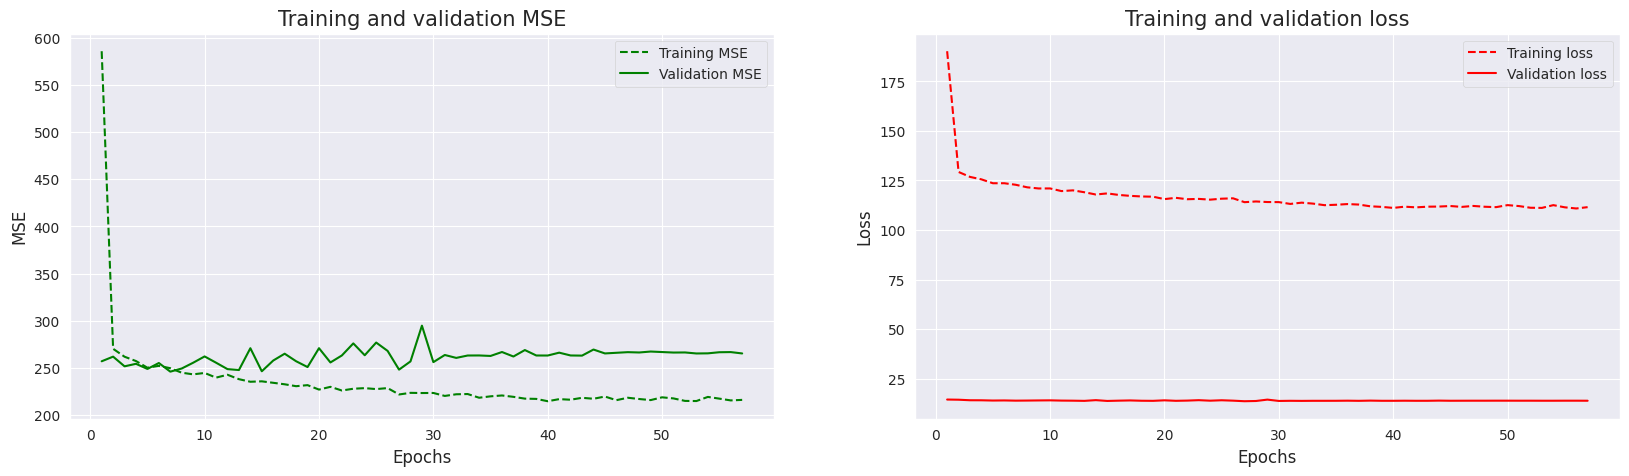

In [15]:
plot_learning_curves(history.history)

MAE: 13.71003717472119
MSE: 285.6208178438662
Spearman's Correlation: 0.3557504407529536
R Squared: 0.13143020868301392


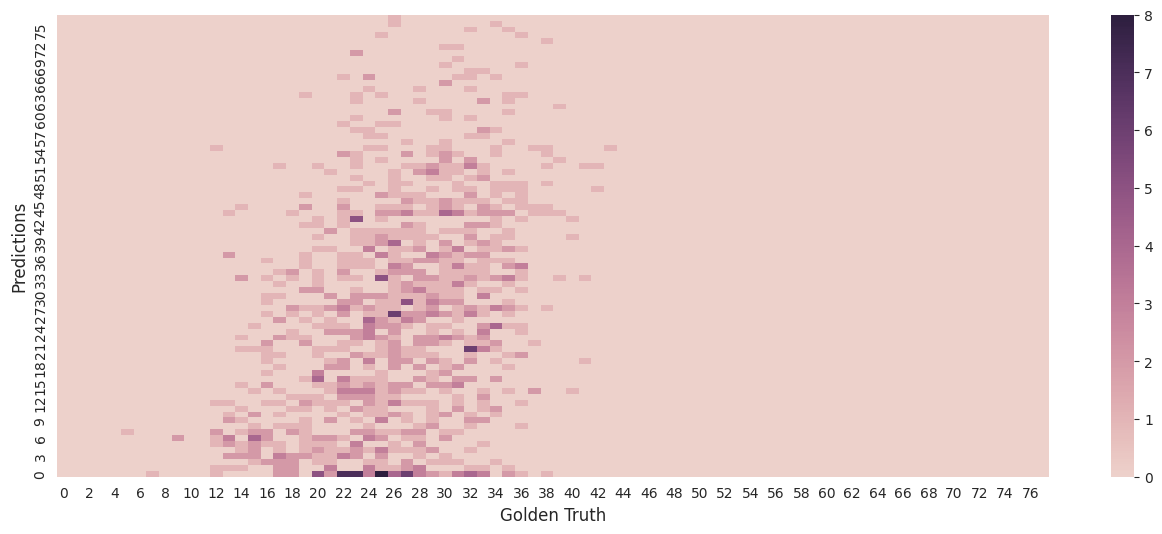

In [21]:
model.load_weights("embedding_model.h5")
mae, mse, sp, r2 = report(model,[X_mel_test, X_audio_test, X_genres_test])

In [10]:
model.load_weights("embedding_model.h5")
layer_name = 'embeddings'
embedding_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

embeddings_train = embedding_layer_model.predict([np.vstack([X_mel_train, X_mel_val]), 
                                                  np.vstack([X_audio_train, X_audio_val]),
                                                  np.vstack([X_genres_train, X_genres_val])])
embeddings_test = embedding_layer_model.predict([X_mel_test, X_audio_test, X_genres_test])
y = pd.concat([y_train, y_val])

2022-11-15 18:10:15.093395: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400712704 exceeds 10% of free system memory.
2022-11-15 18:10:18.854916: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400712704 exceeds 10% of free system memory.
2022-11-15 18:10:21.913575: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 18:10:22.065436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


In [28]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=40, metric='cosine', n_jobs=-1)
knn.fit(embeddings_train)
# select indices of k nearest neighbours

predictions = []
for i in range(0,len(y_test)):
    neighbours = knn.kneighbors([embeddings_test[i]], return_distance = False)
    pred = np.mean(y[neighbours.tolist()[0]]).round(0)
    predictions.append(pred)

In [29]:
predictions = np.array(predictions)

knn_mae = mean_absolute_error(y_test, predictions)
knn_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(predictions, index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()
#R2 = knn.score(X, y_train)

knn_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {knn_mae}\nMSE: {knn_mse}\nSpearman's Correlation {knn_sp[0]}")

MAE: 14.097583643122677
MSE: 295.22026022304834
Spearman's Correlation 0.31568856074805063


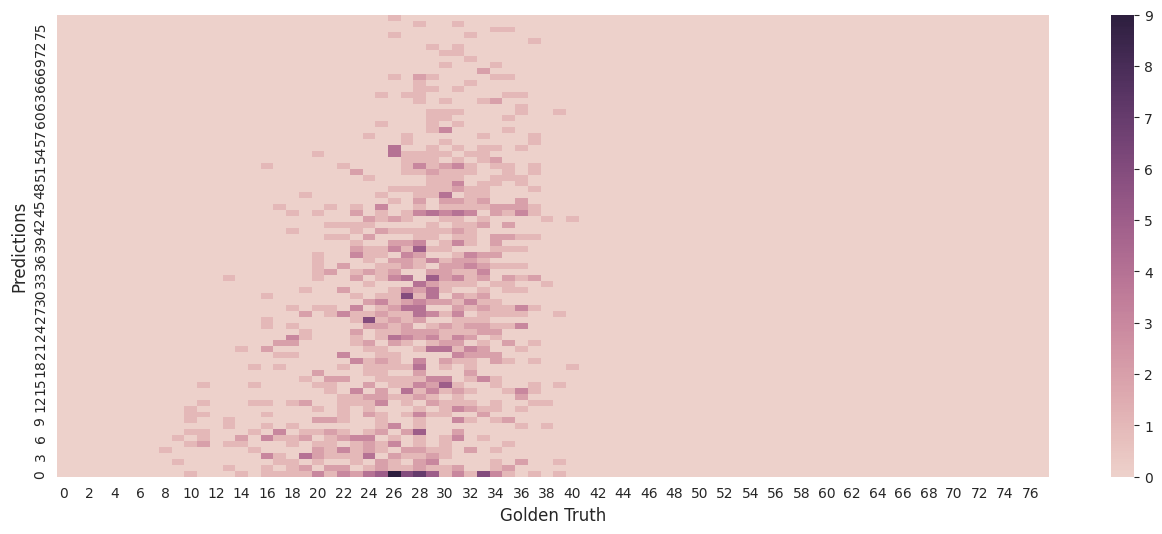

In [30]:
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
#results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

Minimum error:- 0.9721189591078067 at K = 0


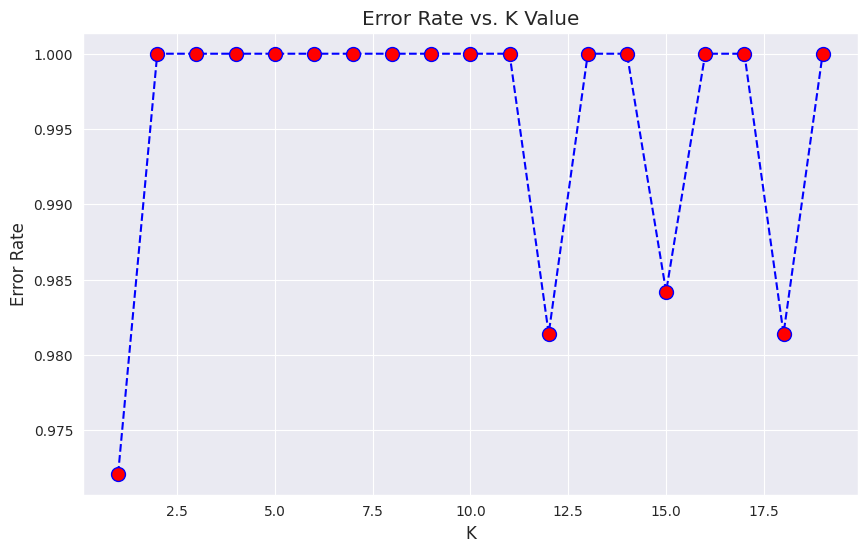

In [17]:
error_rate = []
for i in range(1,20):
    knn = NearestNeighbors(n_neighbors=i, metric='cosine', n_jobs=-1)
    knn.fit(embeddings_train)
    pred_i = np.mean(y[knn.kneighbors([embeddings_test[1]], return_distance = False).tolist()[0]])
    error_rate.append(np.mean(y_test != pred_i))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

# After Song Release

In [8]:
def embedding_model(n_layers=6, n_timesteps = 41, n_features = 2):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    audio_input = Input(shape= (X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")
    views_input = Input(shape=(n_timesteps, n_features), name="VIEWS_INPUT")
    
    #Spectrograms
    x = Conv1D(filters= 128, kernel_size= 11, padding='same', activation='relu')(mel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(n_layers - 1):
        x = Conv1D(32 * (2**i), kernel_size=11, strides=3 , padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=4, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

    x = GlobalAvgPool1D()(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    mel_out = Dropout(0.3)(x)
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    y = Dropout(0.4)(hidden_layer)
    
    hidden_layer = Dense(32, activation = 'swish')(genres_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(96, activation = 'selu')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(256, activation = 'relu')(dropout)
    e = Dropout(0.6)(hidden_layer)
    
    audio_genres_out = Concatenate(axis=1, name="AUDIO_GENRE_OUTPUT")([y, e])
    
    #Views
    bi_gru = Bidirectional(GRU(32, return_sequences=True))(views_input)
    bi_gru = Bidirectional(GRU(32, return_sequences=True))(bi_gru)
    dropout = Dropout(0.1)(bi_gru)
    x = GlobalAvgPool1D()(dropout)
    flatten = Flatten()(x)

    x = Dense(128, activation='relu')(flatten)
    x = Dense(32, activation='elu')(x)
    dropout = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    dropout = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    views_out = Dropout(0.1)(x)

    embeddings =  Concatenate(axis=1, name='embeddings')([mel_out, audio_genres_out, views_out])
    print(embeddings.shape)
    
    out = Dense(1)(embeddings)

    model = Model(inputs=[mel_input, audio_input, genres_input, views_input], outputs=out)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [9]:
keras.backend.clear_session()
model = embedding_model()

2022-11-15 20:04:31.096208: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 20:04:31.097200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 20:04:31.097397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 20:04:31.097538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(None, 480)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1292, 128)    180352      ['MEL_INPUT[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 646, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 646, 128)    512         ['max_pooling1d[0][0]']          
 alization)                                                                       

 dropout_4 (Dropout)            (None, 1, 512)       0           ['batch_normalization_5[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 32)           0           ['dense_3[0][0]']                
                                                                                                  
 dropout_11 (Dropout)           (None, 32)           0           ['dense_8[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 64)           0           ['global_average_pooling1d_1[0][0
                                                                 ]']                              
                                                                                                  
 global_average_pooling1d (Glob  (None, 512)         0           ['dropout_4[0][0]']              
 alAverage

In [11]:
checkpoint = ModelCheckpoint(filepath='after_model.h5', monitor="val_mae", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_mae", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
        [X_mel_train, X_audio_train, X_genres_train, X_views_train], y_train,
        sample_weight=sample_weight,
        validation_data=[[X_mel_val, X_audio_val, X_genres_val, X_views_val], y_val],
        batch_size=16,
        epochs=200,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-15 19:51:46.399743: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 19:51:46.400844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 19:51:46.401047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 19:51:46.401188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(None, 480)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1292, 128)    180352      ['MEL_INPUT[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 646, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 646, 128)    512         ['max_pooling1d[0][0]']          
 alization)                                                                       

 dropout_4 (Dropout)            (None, 1, 512)       0           ['batch_normalization_5[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 32)           0           ['dense_3[0][0]']                
                                                                                                  
 dropout_11 (Dropout)           (None, 32)           0           ['dense_8[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 64)           0           ['global_average_pooling1d_1[0][0
                                                                 ]']                              
                                                                                                  
 global_average_pooling1d (Glob  (None, 512)         0           ['dropout_4[0][0]']              
 alAverage

2022-11-15 19:51:48.485120: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-15 19:51:51.715237: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/200


2022-11-15 19:51:58.517194: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 19:51:58.620757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


538/538 [==============================] - 16s 18ms/step - loss: 179.0897 - mse: 530.7452 - mae: 18.3701 - val_loss: 14.7127 - val_mse: 290.4796 - val_mae: 13.5950 - lr: 1.0000e-04
Epoch 2/200
538/538 [==============================] - 8s 16ms/step - loss: 124.8879 - mse: 252.7376 - mae: 12.9594 - val_loss: 13.6866 - val_mse: 234.1054 - val_mae: 12.5837 - lr: 1.0000e-04
Epoch 3/200
538/538 [==============================] - 8s 16ms/step - loss: 121.0486 - mse: 235.3524 - mae: 12.5824 - val_loss: 13.2697 - val_mse: 219.3330 - val_mae: 12.1893 - lr: 1.0000e-04
Epoch 4/200
538/538 [==============================] - 8s 16ms/step - loss: 118.9128 - mse: 226.8339 - mae: 12.3708 - val_loss: 13.0216 - val_mse: 209.9625 - val_mae: 11.9588 - lr: 1.0000e-04
Epoch 5/200
538/538 [==============================] - 9s 16ms/step - loss: 116.9074 - mse: 219.9477 - mae: 12.1708 - val_loss: 12.9259 - val_mse: 209.4499 - val_mae: 11.8790 - lr: 1.0000e-04
Epoch 6/200
538/538 [==============================

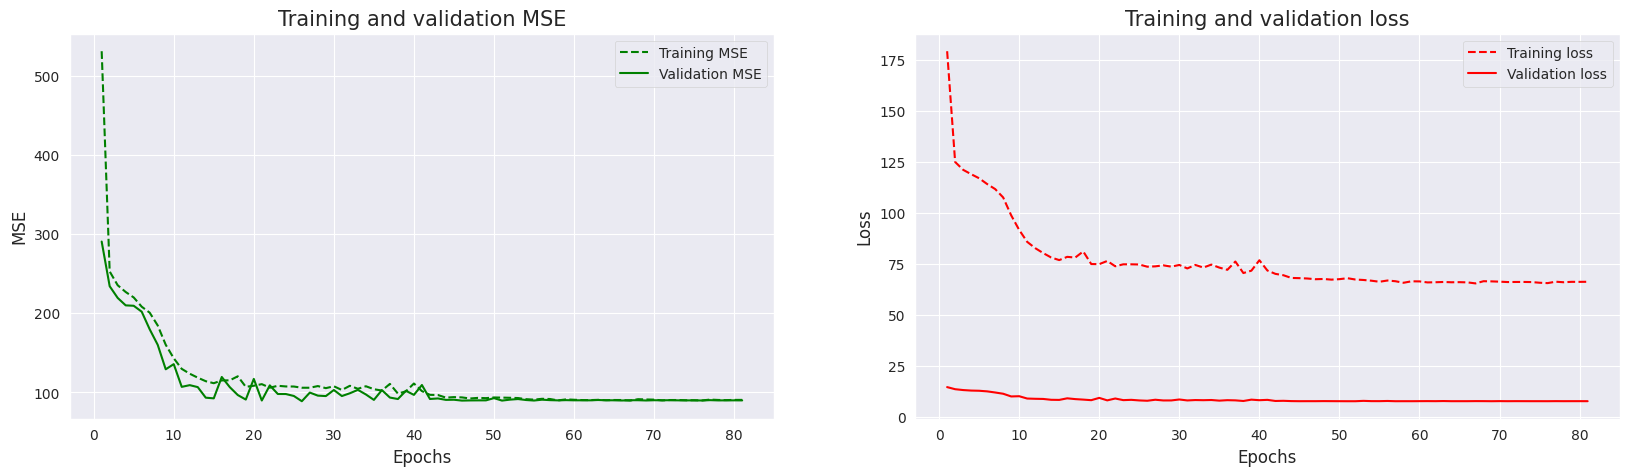

MAE: 9.277881040892193
MSE: 159.06226765799258
Spearman's Correlation: 0.7108183327220626
R Squared: 0.5162934064865112


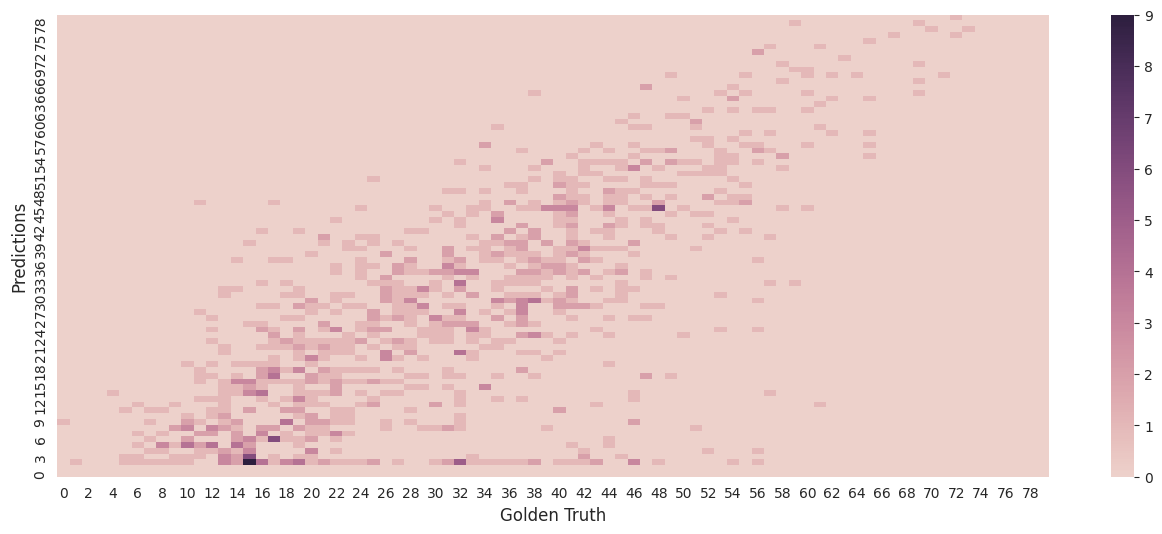

In [13]:
plot_learning_curves(history.history)

model.load_weights("after_model.h5")
mae, mse, sp, r2 = report(model,[X_mel_test, X_audio_test, X_genres_test, X_views_test])

In [10]:
model.load_weights("after_model.h5")
layer_name = 'embeddings'
embedding_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

embeddings_train = embedding_layer_model.predict([np.vstack([X_mel_train, X_mel_val]), 
                                                  np.vstack([X_audio_train, X_audio_val]),
                                                  np.vstack([X_genres_train, X_genres_val]),
                                                  np.vstack([X_views_train, X_views_val])])
embeddings_test = embedding_layer_model.predict([X_mel_test, X_audio_test, X_genres_test, X_views_test])
y = pd.concat([y_train, y_val])

2022-11-15 20:04:39.398005: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400712704 exceeds 10% of free system memory.
2022-11-15 20:04:41.960621: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400712704 exceeds 10% of free system memory.
2022-11-15 20:04:45.595645: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 20:04:45.741625: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


In [18]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=35, metric='cosine', n_jobs=-1)
knn.fit(embeddings_train)
# select indices of k nearest neighbours

predictions = []
for i in range(0,len(y_test)):
    neighbours = knn.kneighbors([embeddings_test[i]], return_distance = False)
    pred = np.mean(y[neighbours.tolist()[0]]).round(0)
    predictions.append(pred)

predictions = np.array(predictions)

knn_mae = mean_absolute_error(y_test, predictions)
knn_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(predictions, index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()
#R2 = knn.score(X, y_train)

knn_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {knn_mae}\nMSE: {knn_mse}\nSpearman's Correlation {knn_sp[0]}")

MAE: 9.866171003717472
MSE: 172.95353159851302
Spearman's Correlation 0.7046227031900616


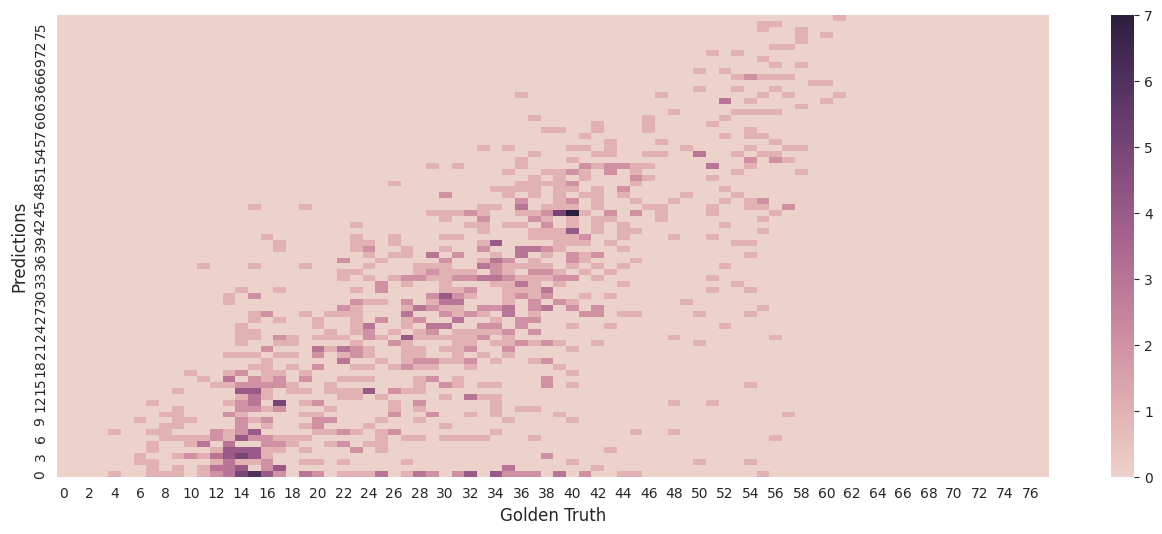

In [12]:
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
#results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);